100%|██████████| 9.91M/9.91M [00:00<00:00, 63.8MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.64MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 14.2MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 7.11MB/s]


Eğitim Başlıyor (Gürültü Faktörü: 0.5)...
Epoch [1/10], Loss: 0.0599
Epoch [2/10], Loss: 0.0360
Epoch [3/10], Loss: 0.0310
Epoch [4/10], Loss: 0.0284
Epoch [5/10], Loss: 0.0267
Epoch [6/10], Loss: 0.0255
Epoch [7/10], Loss: 0.0245
Epoch [8/10], Loss: 0.0235
Epoch [9/10], Loss: 0.0227
Epoch [10/10], Loss: 0.0221

Sonuçlar görselleştiriliyor...


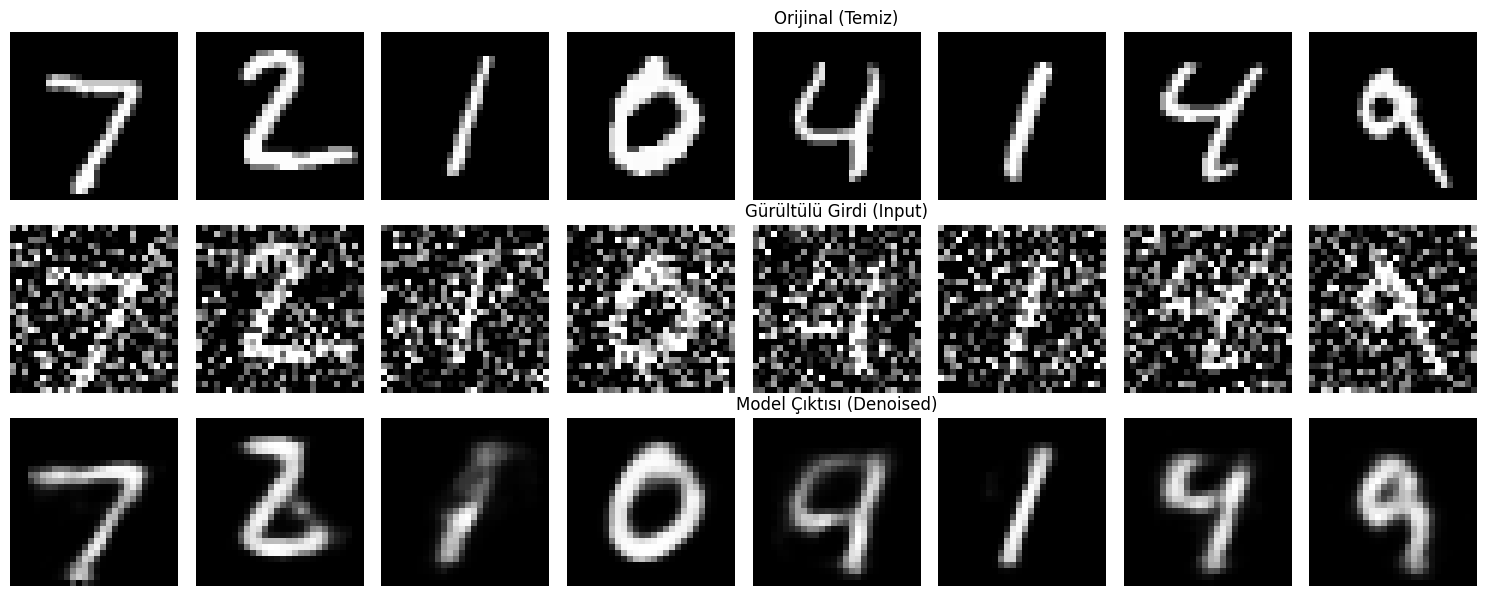

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

# --- 1. Ayarlar ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
BATCH_SIZE = 64
LEARNING_RATE = 1e-3
NUM_EPOCHS = 10
NOISE_FACTOR = 0.5  # Gürültü şiddeti (0.0 - 1.0 arası)

# --- 2. Veri Seti ve Gürültü Fonksiyonu ---
transform = transforms.Compose([transforms.ToTensor()])

train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root='./data', train=False, transform=transform, download=True)

train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False)

def add_noise(images, noise_factor):
    """Görüntülere rastgele Gauss gürültüsü ekler."""
    # Görüntü boyutunda rastgele gürültü oluştur
    noise = torch.randn_like(images) * noise_factor
    noisy_imgs = images + noise
    # Değerlerin 0 ile 1 arasında kalmasını sağla (clip)
    noisy_imgs = torch.clip(noisy_imgs, 0., 1.)
    return noisy_imgs

# --- 3. Model Mimarisi (Aynı AE Yapısı) ---
class DenoisingAutoencoder(nn.Module):
    def __init__(self):
        super(DenoisingAutoencoder, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(28 * 28, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU()
        )
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 28 * 28),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = x.view(-1, 28 * 28)
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        decoded = decoded.view(-1, 1, 28, 28)
        return decoded

model = DenoisingAutoencoder().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

# --- 4. Eğitim Döngüsü ---
print(f"Eğitim Başlıyor (Gürültü Faktörü: {NOISE_FACTOR})...")

for epoch in range(NUM_EPOCHS):
    train_loss = 0.0
    for data in train_loader:
        img_clean, _ = data # Temiz görüntüler (HEDEFİMİZ)
        img_clean = img_clean.to(device)
        
        # 1. Görüntülere Gürültü Ekle (GİRDİMİZ)
        img_noisy = add_noise(img_clean, NOISE_FACTOR)
        img_noisy = img_noisy.to(device)
        
        # 2. Forward Pass (Gürültülü görüntüyü modele ver)
        output = model(img_noisy)
        
        # 3. Loss Hesapla 
        # DİKKAT: Çıktıyı (output) TEMİZ GÖRÜNTÜ (img_clean) ile kıyaslıyoruz!
        loss = criterion(output, img_clean)
        
        # 4. Backward Pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
    
    print(f'Epoch [{epoch+1}/{NUM_EPOCHS}], Loss: {train_loss/len(train_loader):.4f}')

# --- 5. Sonuçları Görselleştirme ---
print("\nSonuçlar görselleştiriliyor...")
model.eval()
with torch.no_grad():
    # Test setinden temiz görüntüler al
    clean_images, _ = next(iter(test_loader))
    clean_images = clean_images.to(device)
    
    # Onları gürültülü hale getir
    noisy_images = add_noise(clean_images, NOISE_FACTOR)
    
    # Modelden geçir (Gürültüyü temizlemesini iste)
    denoised_images = model(noisy_images)

    # CPU'ya al
    clean_images = clean_images.cpu()
    noisy_images = noisy_images.cpu()
    denoised_images = denoised_images.cpu()

    # Çizim
    n = 8 # Gösterilecek örnek sayısı
    plt.figure(figsize=(15, 6))
    
    for i in range(n):
        # 1. Satır: Orijinal (Temiz)
        ax = plt.subplot(3, n, i + 1)
        plt.imshow(clean_images[i].squeeze(), cmap='gray')
        if i == n//2: plt.title("Orijinal (Temiz)")
        plt.axis('off')
        
        # 2. Satır: Gürültülü (Girdi)
        ax = plt.subplot(3, n, i + 1 + n)
        plt.imshow(noisy_images[i].squeeze(), cmap='gray')
        if i == n//2: plt.title("Gürültülü Girdi (Input)")
        plt.axis('off')
        
        # 3. Satır: Temizlenmiş (Çıktı)
        ax = plt.subplot(3, n, i + 1 + 2*n)
        plt.imshow(denoised_images[i].squeeze(), cmap='gray')
        if i == n//2: plt.title("Model Çıktısı (Denoised)")
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()